In [512]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [513]:
nba = pd.read_csv("NBADataJan122024.csv")
#get rid of Rk column as it it just an ID number
nba = nba.drop(columns=nba.columns[0])
nba["WinPercentage"]=np.round(nba.WINS/nba.G, 2)
nba.head()

,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,TRB,AST,STL,BLK,TOV,PF,PTS,WINS,LOSSES,WinPercentage
0,Memphis Grizzlies,39,240.0,44.9,93.2,0.482,14.0,38.0,0.368,30.9,...,48.5,29.9,9.2,6.4,17.3,21.3,123.0,25,14,0.64
1,Cleveland Cavaliers,37,240.0,45.2,89.6,0.505,16.3,40.4,0.405,28.9,...,43.6,29.4,8.8,4.6,13.0,18.2,122.9,33,4,0.89
2,Denver Nuggets,37,242.7,45.1,90.4,0.499,11.9,31.1,0.382,33.2,...,45.3,31.5,8.8,4.7,14.1,18.1,120.6,22,15,0.59
3,Chicago Bulls,38,240.7,43.4,92.3,0.471,16.4,43.8,0.375,27.0,...,45.3,29.6,7.7,4.7,15.1,18.1,118.2,18,20,0.47
4,Boston Celtics,38,242.0,41.6,90.6,0.460,18.0,49.5,0.364,23.6,...,44.9,25.4,7.6,5.7,12.0,16.1,117.9,27,11,0.71


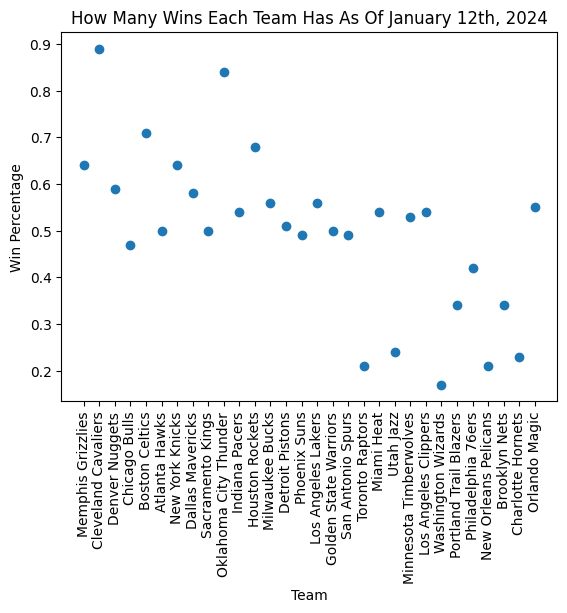

In [514]:
plt.scatter(nba.Team, nba.WinPercentage)
plt.title("How Many Wins Each Team Has As Of January 12th, 2024")
plt.xlabel("Team")
plt.ylabel("Win Percentage")
plt.xticks(rotation=90)
plt.show()

In [515]:
from sklearn import neighbors, datasets, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [516]:
#Use FG, FGA, FG%, 3P, 3PA, 3P%, 2P, 2PA, 2P%, FT, FTA, FT%, ORB, DRB, TRB, AST, STL, BLK, TOV, PF, PTS to predict Win Percentage
X, y = nba.iloc[:, 3:24], nba["WinPercentage"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

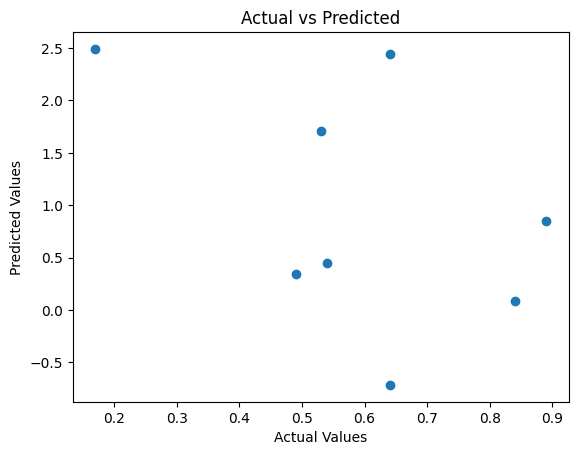

In [517]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.show()

In [518]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE, MSE, RMSE, and R-squared
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

Mean Absolute Error: 0.9608547542988961
Mean Squared Error: 1.5569783592003208
Root Mean Squared Error: 1.2477893889596596
R-squared: -34.59316151908149


In [519]:
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Difference': y_test - y_pred
})

print(comparison_df.head())

    Actual  Predicted  Difference
1     0.89   0.852489    0.037511
0     0.64   2.441652   -1.801652
14    0.49   0.345006    0.144994
9     0.84   0.084759    0.755241
21    0.53   1.704189   -1.174189


In [520]:
#Ordinary Least Squares
import statsmodels.api as sm

x_OLS, y_OLS = nba.iloc[:, 3:24], nba["WinPercentage"]

x_OLS = sm.add_constant(x_OLS)

result = sm.OLS(y_OLS, x_OLS).fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          WinPercentage   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     5.196
Date:                Mon, 13 Jan 2025   Prob (F-statistic):             0.0109
Time:                        13:15:28   Log-Likelihood:                 50.458
No. Observations:                  30   AIC:                            -56.92
Df Residuals:                       8   BIC:                            -26.09
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7585     33.610     -0.052      0.9

In [521]:
#Since there is probably strong multicollinearity, let's do some feature selection to get a simpler model

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
# Sequential Backward Selection(sfs)
sfs = SFS(LinearRegression(),
          k_features=(1,21),
          forward=False,
          floating=False,
          scoring = 'r2',
          cv = 0)
sfs.fit(x_OLS, y_OLS)

SequentialFeatureSelector(cv=0, estimator=LinearRegression(), forward=False,
                          k_features=(1, 21), scoring='r2')

/Users/jennaiphone/Desktop/NBA/NBAproj/lib/python3.11/site-packages/mlxtend/feature_selection/sequential_feature_selector.py:895: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  std_err = scipy.stats.sem(ary)


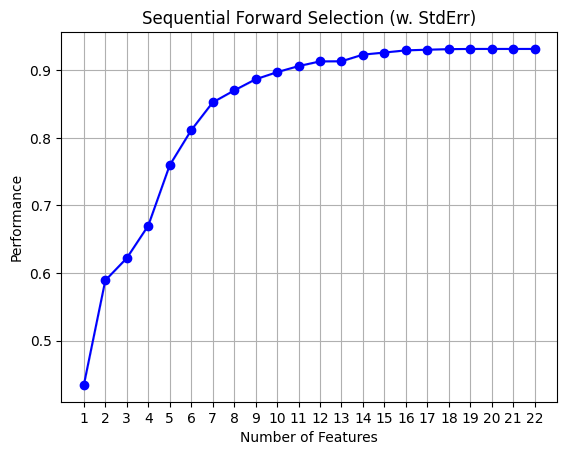

In [522]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [527]:
sfs = SFS(LinearRegression(),
          k_features=9,
          forward=False,
          floating=False,
          scoring = 'r2',
          cv = 0)
sfs.fit(x_OLS, y_OLS)
sfs.k_feature_names_

('FG', 'FGA', '3PA', '3P%', '2PA', 'ORB', 'DRB', 'STL', 'TOV')

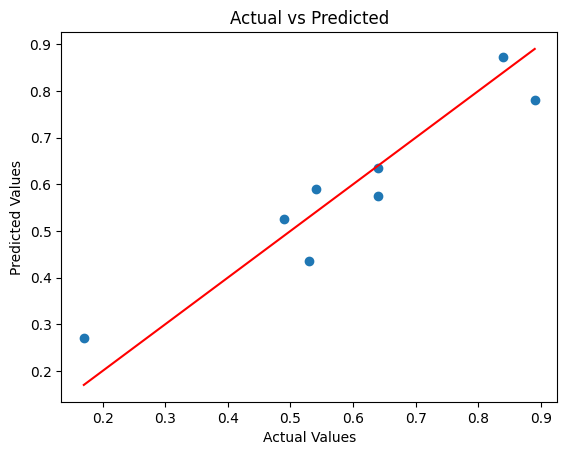

In [524]:
X_red, y_red = X[['FG', 'FGA', '3PA', '3P%', '2PA', 'ORB', 'DRB', 'STL', 'TOV']], y
X_train, X_test, y_train, y_test = train_test_split(X_red, y_red, random_state=2)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

lr_red = LinearRegression()
lr_red.fit(X_train, y_train)

y_pred = lr_red.predict(X_test)

plt.scatter(y_test, y_pred)
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.show()

In [525]:
# Calculate MAE, MSE, RMSE, and R-squared
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

Mean Absolute Error: 0.06114076927386827
Mean Squared Error: 0.004953768285710418
Root Mean Squared Error: 0.07038301134301102
R-squared: 0.8867548327312949


In [526]:
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Difference': y_test - y_pred
})

print(comparison_df.head())

    Actual  Predicted  Difference
1     0.89   0.781017    0.108983
0     0.64   0.575490    0.064510
14    0.49   0.526601   -0.036601
9     0.84   0.871645   -0.031645
21    0.53   0.436465    0.093535
